# TD — Neural Networks with PyTorch
**Paris Dauphine — M2 | Duration: 3h**

---

## Outline
1. **Part 1 — Theory**: Perceptron → Hidden Layers → Activation Functions & Vanishing Gradient  
2. **Part 2 — Guided Exercises**: Regression, Classification, Activation Functions, Non-Linear Relations  
3. **Part 3 — Project**: MNIST Handwritten Digit Classification  

---

## Setup — Install & Import

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.10.0+cpu
Device: CPU


---
# Part 1 — Theory

---

## 1.1 The Perceptron (No Hidden Layer)

The **perceptron** is the simplest neural network: a single layer that maps inputs directly to an output.

$$\hat{y} = f\left(\sum_{i=1}^{n} w_i x_i + b\right) = f(\mathbf{w}^T \mathbf{x} + b)$$

- $\mathbf{x} \in \mathbb{R}^n$: input features  
- $\mathbf{w} \in \mathbb{R}^n$: learned weights  
- $b \in \mathbb{R}$: bias  
- $f$: activation function  

**Key limitation**: a perceptron can only learn **linearly separable** functions. It cannot solve XOR, for instance.

```
x1 ──┐
      ├──[w1, w2, b]──> f(z) ──> ŷ
x2 ──┘
```

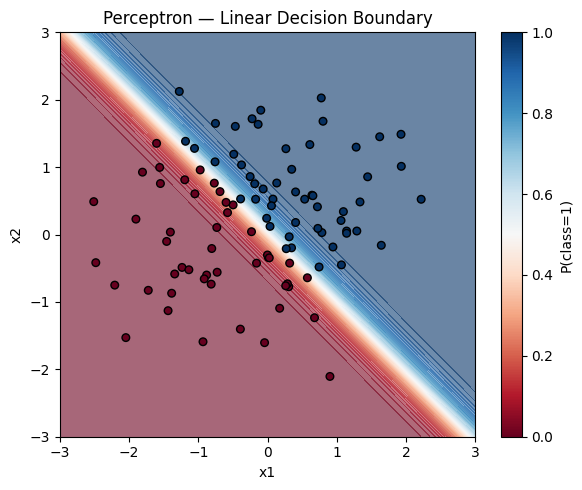

In [5]:
# --- Perceptron illustration ---
# Linear decision boundary on a 2D dataset

# Generate linearly separable data
N = 100
X_lin = torch.randn(N, 2)
y_lin = (X_lin[:, 0] + X_lin[:, 1] > 0).float()

# Perceptron = Linear layer + Sigmoid
perceptron = nn.Sequential(nn.Linear(2, 1), nn.Sigmoid())
optimizer = optim.SGD(perceptron.parameters(), lr=0.5)
criterion = nn.BCELoss()

for _ in range(500):
    pred = perceptron(X_lin).squeeze()
    loss = criterion(pred, y_lin)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot decision boundary
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    zz = perceptron(grid).squeeze().numpy().reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, zz, levels=50, cmap='RdBu', alpha=0.6)
plt.scatter(X_lin[:, 0], X_lin[:, 1], c=y_lin, cmap='RdBu', edgecolors='k', s=30)
plt.title('Perceptron — Linear Decision Boundary')
plt.xlabel('x1'); plt.ylabel('x2')
plt.colorbar(label='P(class=1)')
plt.tight_layout()
plt.show()

## 1.2 One Hidden Layer — The True "Neural Network"

Adding a hidden layer gives the network the ability to learn **non-linear** transformations:

$$\mathbf{h} = f_1(W_1 \mathbf{x} + \mathbf{b}_1)$$
$$\hat{y} = f_2(W_2 \mathbf{h} + \mathbf{b}_2)$$

- $W_1 \in \mathbb{R}^{d \times n}$: weights of the hidden layer (maps input to $d$ neurons)  
- $W_2 \in \mathbb{R}^{k \times d}$: weights of the output layer (maps $d$ neurons to $k$ outputs)  

```
x1 ──┐          h1 ──┐
x2 ──┼──[W1,b1]──h2 ──┼──[W2,b2]──> ŷ
x3 ──┘          h3 ──┘
```

> **Universal Approximation Theorem**: A neural network with one hidden layer and enough neurons can approximate *any* continuous function on a compact subset of $\mathbb{R}^n$.

## 1.3 Deep Networks — Multiple Hidden Layers (MLP)

Stacking $L$ hidden layers creates a **Multi-Layer Perceptron (MLP)**:

$$\mathbf{h}^{(l)} = f_l\left(W^{(l)} \mathbf{h}^{(l-1)} + \mathbf{b}^{(l)}\right), \quad l = 1, \dots, L$$

Each layer learns increasingly **abstract representations**:
- Layer 1 → edges, simple patterns  
- Layer 2 → combinations of patterns  
- Layer L → high-level concepts

## 1.4 Activation Functions & the Vanishing Gradient Problem

Without a non-linear activation, stacking layers collapses to a single linear transformation. Activation functions introduce non-linearity, but they also affect how gradients flow during backpropagation.

### Common Activation Functions

| Function | Formula | Range | Issue |
|---|---|---|---|
| **Sigmoid** | $\sigma(x) = \frac{1}{1+e^{-x}}$ | $(0, 1)$ | Vanishing gradient |
| **Tanh** | $\tanh(x)$ | $(-1, 1)$ | Vanishing gradient |
| **ReLU** | $\max(0, x)$ | $[0, +\infty)$ | Dying ReLU |
| **Leaky ReLU** | $\max(\alpha x, x)$ | $(-\infty, +\infty)$ | Stable |

### The Vanishing Gradient Problem

For **Sigmoid**, the derivative is: $\sigma'(x) = \sigma(x)(1 - \sigma(x)) \leq 0.25$

When backpropagating through $L$ layers, the gradient is multiplied by this factor $L$ times:
$$\left|\frac{\partial \mathcal{L}}{\partial W^{(1)}}\right| \approx 0.25^L \to 0 \text{ as } L \to \infty$$

**Early layers stop learning** — their weights are barely updated. **ReLU** has a gradient of exactly 1 for positive inputs, which avoids this issue.

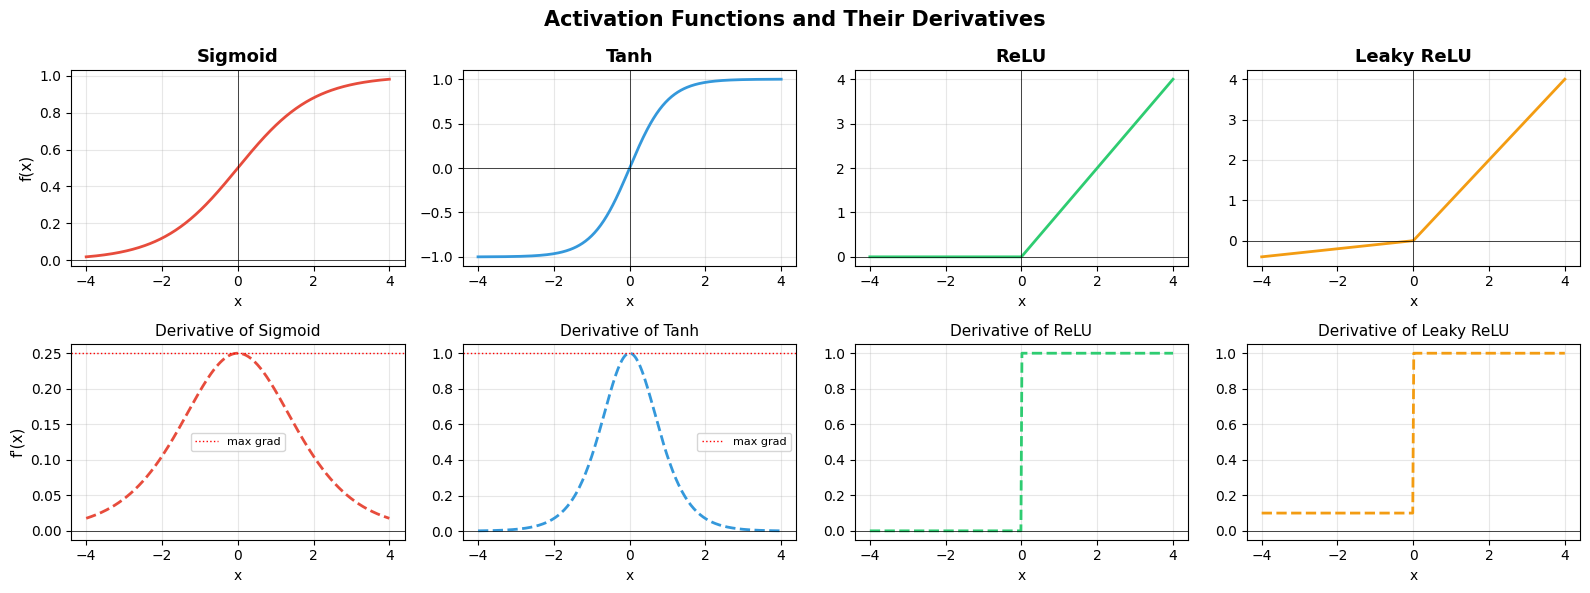

Note: Sigmoid derivative is bounded by 0.25 → vanishing gradient in deep networks!
ReLU derivative is 1 for x>0 → gradient flows freely.


In [29]:
# --- Visualize activation functions and their derivatives ---

x = torch.linspace(-4, 4, 300, requires_grad=False)

activations = {
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'ReLU': nn.ReLU(),
    'Leaky ReLU': nn.LeakyReLU(0.1),
}

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for i, (name, fn) in enumerate(activations.items()):
    # Compute output
    x_in = x.clone().requires_grad_(True)
    y_out = fn(x_in)
    y_np = y_out.detach().numpy()

    # Compute derivative
    grad = torch.autograd.grad(y_out.sum(), x_in)[0].numpy()

    # Plot function
    axes[0, i].plot(x.numpy(), y_np, color=colors[i], lw=2)
    axes[0, i].set_title(f'{name}', fontsize=13, fontweight='bold')
    axes[0, i].set_xlabel('x'); axes[0, i].axhline(0, color='k', lw=0.5); axes[0, i].axvline(0, color='k', lw=0.5)
    axes[0, i].grid(True, alpha=0.3)

    # Plot derivative
    axes[1, i].plot(x.numpy(), grad, color=colors[i], lw=2, linestyle='--')
    axes[1, i].set_title(f"Derivative of {name}", fontsize=11)
    axes[1, i].set_xlabel('x'); axes[1, i].axhline(0, color='k', lw=0.5)
    axes[1, i].grid(True, alpha=0.3)
    if name in ['Sigmoid', 'Tanh']:
        axes[1, i].axhline(0.25 if name == 'Sigmoid' else 1.0, color='red', lw=1, linestyle=':', label='max grad')
        axes[1, i].legend(fontsize=8)

axes[0, 0].set_ylabel('f(x)', fontsize=11)
axes[1, 0].set_ylabel("f'(x)", fontsize=11)
fig.suptitle('Activation Functions and Their Derivatives', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("Note: Sigmoid derivative is bounded by 0.25 → vanishing gradient in deep networks!")
print("ReLU derivative is 1 for x>0 → gradient flows freely.")

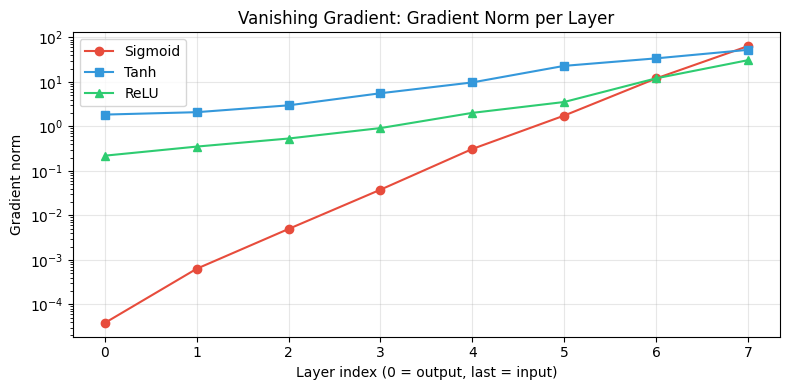

Sigmoid: gradient norm collapses in early layers → those weights barely update.
Tanh/ReLU: gradient stays stable → deep networks can train effectively.


In [30]:
# --- Vanishing gradient: visualize gradient norm per layer ---

def measure_gradients(activation_fn, n_layers=8):
    """Build a deep network and measure gradient norm at each layer."""
    layers = []
    for _ in range(n_layers):
        layers += [nn.Linear(32, 32), activation_fn]
    model = nn.Sequential(*layers)

    # Forward pass with random input
    x_in = torch.randn(16, 32)
    out = model(x_in).sum()
    out.backward()

    # Collect gradient norms for Linear layers only
    grad_norms = []
    for module in model.modules():
        if isinstance(module, nn.Linear) and module.weight.grad is not None:
            grad_norms.append(module.weight.grad.norm().item())
    return grad_norms

sigmoid_grads = measure_gradients(nn.Sigmoid(), n_layers=8)
relu_grads    = measure_gradients(nn.ReLU(),    n_layers=8)
tanh_grads    = measure_gradients(nn.Tanh(),    n_layers=8)

plt.figure(figsize=(8, 4))
plt.plot(sigmoid_grads, 'o-', label='Sigmoid', color='#e74c3c')
plt.plot(tanh_grads,    's-', label='Tanh',    color='#3498db')
plt.plot(relu_grads,    '^-', label='ReLU',    color='#2ecc71')
plt.xlabel('Layer index (0 = output, last = input)')
plt.ylabel('Gradient norm')
plt.title('Vanishing Gradient: Gradient Norm per Layer')
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Sigmoid: gradient norm collapses in early layers → those weights barely update.")
print("Tanh/ReLU: gradient stays stable → deep networks can train effectively.")

---
# Part 2 — Guided Exercises

---

## Exercise 1 (with solution) — Regression with MSE Loss

**Goal**: train a network to predict a continuous target $y$ from features $X$, minimising:

$$\mathcal{L}_{MSE} = \frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2$$

We generate data from: $y = 3x_1 - 2x_2 + \epsilon$, $\epsilon \sim \mathcal{N}(0, 0.1)$

In [8]:
# --- Data Generation ---
torch.manual_seed(42)
N = 500
X_reg = torch.randn(N, 2)
y_reg = (3 * X_reg[:, 0] - 2 * X_reg[:, 1] + 0.1 * torch.randn(N)).unsqueeze(1)

# Train/test split
split = int(0.8 * N)
X_train_r, X_test_r = X_reg[:split], X_reg[split:]
y_train_r, y_test_r = y_reg[:split], y_reg[split:]

print(f"Train: {X_train_r.shape}, Test: {X_test_r.shape}")
print(f"y range: [{y_reg.min():.2f}, {y_reg.max():.2f}]")

Train: torch.Size([400, 2]), Test: torch.Size([100, 2])
y range: [-10.22, 9.50]


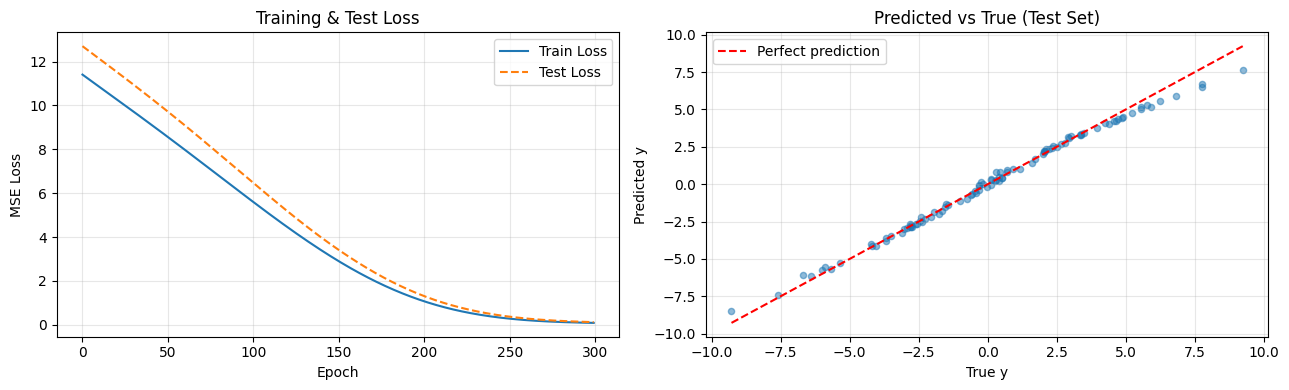

Final Test MSE: 0.12288


In [31]:
class RegressionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model_reg = RegressionNet()
criterion_reg = nn.MSELoss()
optimizer_reg = optim.Adam(model_reg.parameters(), lr=1e-3)

# --- Training Loop ---
train_losses, test_losses = [], []
EPOCHS = 300

for epoch in range(EPOCHS):
    model_reg.train()
    pred_train = model_reg(X_train_r)
    loss_train = criterion_reg(pred_train, y_train_r)

    optimizer_reg.zero_grad()
    loss_train.backward()
    optimizer_reg.step()

    model_reg.eval()
    with torch.no_grad():
        loss_test = criterion_reg(model_reg(X_test_r), y_test_r)

    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())

# --- Plot Results ---
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Loss curves
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(test_losses,  label='Test Loss', linestyle='--')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training & Test Loss')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Predicted vs True
with torch.no_grad():
    y_pred_test = model_reg(X_test_r).squeeze().numpy()
y_true_test = y_test_r.squeeze().numpy()

axes[1].scatter(y_true_test, y_pred_test, alpha=0.5, s=20)
lims = [y_true_test.min(), y_true_test.max()]
axes[1].plot(lims, lims, 'r--', label='Perfect prediction')
axes[1].set_xlabel('True y'); axes[1].set_ylabel('Predicted y')
axes[1].set_title('Predicted vs True (Test Set)')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_mse = criterion_reg(model_reg(X_test_r), y_test_r).item()
print(f"Final Test MSE: {final_mse:.5f}")

---
## Exercise 2 — Classification with Cross-Entropy Loss

**Goal**: classify points into $K=3$ classes using:

$$\mathcal{L}_{CE} = -\frac{1}{n} \sum_{i=1}^n \sum_{k=1}^K y_{ik} \log(\hat{p}_{ik})$$

In PyTorch, `nn.CrossEntropyLoss` combines `LogSoftmax` + `NLLLoss` — you **do not** add a Softmax at the end of your model.

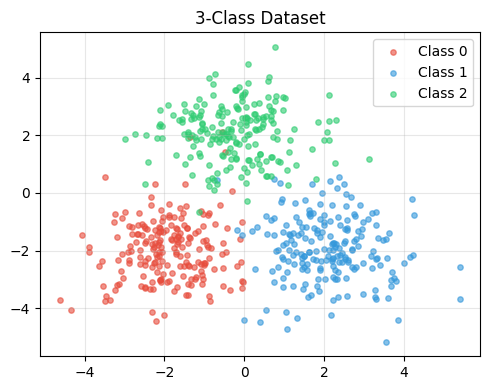

In [11]:
# --- Data Generation: 3 Gaussian clusters ---
torch.manual_seed(0)

def make_blobs(n_per_class=200, centers=None):
    centers = centers or [[-2, -2], [2, -2], [0, 2]]
    X_list, y_list = [], []
    for k, c in enumerate(centers):
        X_list.append(torch.randn(n_per_class, 2) + torch.tensor(c, dtype=torch.float))
        y_list.append(torch.full((n_per_class,), k, dtype=torch.long))
    return torch.cat(X_list), torch.cat(y_list)

X_cls, y_cls = make_blobs(n_per_class=200)

# Split
idx = torch.randperm(len(X_cls))
split = int(0.8 * len(X_cls))
X_train_c, X_test_c = X_cls[idx[:split]], X_cls[idx[split:]]
y_train_c, y_test_c = y_cls[idx[:split]], y_cls[idx[split:]]

# Visualize
plt.figure(figsize=(5, 4))
colors_cls = ['#e74c3c', '#3498db', '#2ecc71']
for k in range(3):
    mask = y_cls == k
    plt.scatter(X_cls[mask, 0], X_cls[mask, 1], s=15, alpha=0.6, label=f'Class {k}', color=colors_cls[k])
plt.title('3-Class Dataset'); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

In [ ]:
# EXERCISE 2: Define your classification model
# Build a MLP with:
#   - Input: 2
#   - Hidden layer 1: 64 neurons, ReLU
#   - Hidden layer 2: 32 neurons, ReLU
#   - Output: 3 neurons (one per class), NO activation (CrossEntropyLoss handles it)

class ClassificationNet(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO
        pass

    def forward(self, x):
        # TODO
        pass

# model_cls = ClassificationNet()

# --- Training ---
cls_train_losses, cls_train_accs = [], []

for epoch in range(300):
    model_cls.train()
    logits = model_cls(X_train_c)
    loss = criterion_cls(logits, y_train_c)
    optimizer_cls.zero_grad()
    loss.backward()
    optimizer_cls.step()

    acc = (logits.argmax(1) == y_train_c).float().mean().item()
    cls_train_losses.append(loss.item())
    cls_train_accs.append(acc)

# --- Decision boundary + metrics ---
def plot_decision_boundary(model, X, y, title='Decision Boundary'):
    model.eval()
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 300),
                         np.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 300))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        zz = model(grid).argmax(1).numpy().reshape(xx.shape)
    plt.contourf(xx, yy, zz, alpha=0.3, cmap='Set1', levels=[-0.5, 0.5, 1.5, 2.5])
    for k in range(3):
        mask = y == k
        plt.scatter(X[mask, 0], X[mask, 1], s=15, alpha=0.7, label=f'Class {k}', color=colors_cls[k])
    plt.title(title); plt.legend(fontsize=8); plt.grid(True, alpha=0.3)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plt.sca(axes[0])
axes[0].plot(cls_train_losses); axes[0].set_title('Cross-Entropy Loss'); axes[0].set_xlabel('Epoch'); axes[0].grid(True, alpha=0.3)

plt.sca(axes[1])
axes[1].plot(cls_train_accs, color='green'); axes[1].set_title('Train Accuracy'); axes[1].set_xlabel('Epoch'); axes[1].grid(True, alpha=0.3)

plt.sca(axes[2])
plot_decision_boundary(model_cls, X_test_c.numpy(), y_test_c.numpy(), 'Decision Boundary (Test)')

plt.tight_layout(); plt.show()

with torch.no_grad():
    test_acc = (model_cls(X_test_c).argmax(1) == y_test_c).float().mean().item()
print(f"Test Accuracy: {test_acc * 100:.1f}%")

---
## Exercise 3 — Impact of Activation Function Choice

**Goal**: compare Sigmoid, Tanh, ReLU and Leaky ReLU on the same classification task with a deeper network. Observe how the choice of activation impacts convergence speed and final accuracy.

In [33]:
# EXERCISE 3: Fill in the training function below
# The model will be a 4-hidden-layer MLP using `activation` at each hidden layer.
# Train for 400 epochs with Adam (lr=1e-3) and CrossEntropyLoss.
# Return the list of training losses.

def build_deep_net(activation):
    """4-hidden-layer MLP with given activation (input=2, output=3)."""
    # TODO: build a Sequential with 4 hidden layers of 64 neurons each
    pass

def train_net(model, X_tr, y_tr, epochs=400, lr=1e-3):
    """Train model, return list of losses."""
    # TODO
    pass

torch.manual_seed(42)
activation_configs = {
    'Sigmoid':    nn.Sigmoid(),
    'Tanh':       nn.Tanh(),
    'ReLU':       nn.ReLU(),
    'Leaky ReLU': nn.LeakyReLU(0.1),
}

results_activation = {}
for name, act in activation_configs.items():
    torch.manual_seed(42)
    net = build_deep_net(act)
    losses = train_net(net, X_train_c, y_train_c)
    with torch.no_grad():
        acc = (net(X_test_c).argmax(1) == y_test_c).float().mean().item()
    results_activation[name] = {'losses': losses, 'acc': acc, 'model': net}
    print(f"{name:12s} | Final Loss: {losses[-1]:.4f} | Test Acc: {acc*100:.1f}%")

# --- Plot comparison ---
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

colors_act = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
for (name, res), col in zip(results_activation.items(), colors_act):
    axes[0].plot(res['losses'], label=name, color=col)
axes[0].set_title('Training Loss by Activation Function')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('CE Loss')
axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 2)

names_act = list(results_activation.keys())
accs_act  = [results_activation[n]['acc'] * 100 for n in names_act]
bars = axes[1].bar(names_act, accs_act, color=colors_act, edgecolor='black')
axes[1].set_ylabel('Test Accuracy (%)')
axes[1].set_title('Final Test Accuracy by Activation')
axes[1].set_ylim(50, 105)
for bar, acc in zip(bars, accs_act):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{acc:.1f}%', ha='center', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout(); plt.show()
print("\n→ Sigmoid struggles with a 4-layer deep net due to vanishing gradients.")
print("→ ReLU and Leaky ReLU converge faster and achieve higher accuracy.")

---
## Exercise 4 — Learning Non-Linear Relationships

**Goal**: approximate the function $y = \sin(2\pi x)$ using a neural network. A linear model cannot do this — only a network with non-linear activations can.

We compare: **Linear model** vs **MLP with ReLU**.

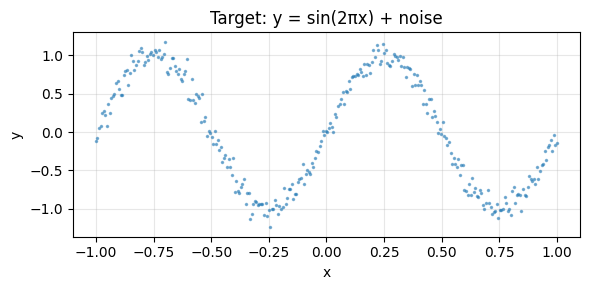

In [34]:
# --- Data ---
torch.manual_seed(0)
X_nl = torch.linspace(-1, 1, 300).unsqueeze(1)
y_nl = torch.sin(2 * np.pi * X_nl) + 0.1 * torch.randn_like(X_nl)

plt.figure(figsize=(6, 3))
plt.plot(X_nl.numpy(), y_nl.numpy(), '.', markersize=3, alpha=0.5)
plt.title('Target: y = sin(2πx) + noise')
plt.xlabel('x'); plt.ylabel('y'); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

In [17]:
# EXERCISE 4:
# (a) Train a pure linear model (nn.Linear(1,1)) on this data for 2000 epochs.
# (b) Train a MLP with 3 hidden layers (32 neurons each, ReLU) for 2000 epochs.
# Plot both predictions vs the true function.
# Conclude: can a linear model approximate sin(2πx)?

# TODO
def train_regression(model, X, y, epochs=2000, lr=1e-3):
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = ...
    for _ in range(epochs):
        model.train()
        loss = ...
        opt.zero_grad(); loss.backward(); opt.step()
    return crit(model(X), y).item()

torch.manual_seed(42)

# (a) Linear model
linear_model = ...
mse_linear = train_regression(linear_model, X_nl, y_nl)

# (b) MLP
mlp_nl = nn.Sequential(
    nn.Linear(1, 32), nn.ReLU(),
    nn.Linear(32, 32), nn.ReLU(),
    nn.Linear(32, 32), nn.ReLU(),
    nn.Linear(32, 1)
)
mse_mlp = train_regression(mlp_nl, X_nl, y_nl)

# --- Plot ---
X_plot = torch.linspace(-1, 1, 500).unsqueeze(1)
y_true_plot = torch.sin(2 * np.pi * X_plot)

with torch.no_grad():
    y_linear_plot = linear_model(X_plot)
    y_mlp_plot    = mlp_nl(X_plot)

plt.figure(figsize=(9, 4))
plt.scatter(X_nl.numpy(), y_nl.numpy(), s=5, alpha=0.3, label='Noisy data', color='gray')
plt.plot(X_plot.numpy(), y_true_plot.numpy(),   'k-',  lw=2, label='True: sin(2πx)')
plt.plot(X_plot.numpy(), y_linear_plot.numpy(), 'r--', lw=2, label=f'Linear (MSE={mse_linear:.4f})')
plt.plot(X_plot.numpy(), y_mlp_plot.numpy(),    'b-',  lw=2, label=f'MLP ReLU (MSE={mse_mlp:.4f})')
plt.title('Linear Model vs MLP: Learning sin(2πx)')
plt.xlabel('x'); plt.ylabel('y')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

print(f"Linear MSE : {mse_linear:.4f}  → cannot capture the non-linearity")
print(f"MLP MSE    : {mse_mlp:.4f}  → closely approximates sin(2πx)")
print("\nConclusion: non-linear activations are essential for learning non-linear functions.")

---
# Part 3 — Project: MNIST Digit Classification

---

**MNIST** is a dataset of **70,000 grayscale images** (28×28 pixels) of handwritten digits (0–9).  
- 60,000 training images, 10,000 test images  
- Each image is flattened to a vector of size **784**  
- Output: **10 classes** (digits 0 to 9)  

**Objective**: reach **>97% test accuracy** using a well-tuned MLP.

The project is structured in 5 steps.

### Step 1 — Load and Explore MNIST

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 12.2MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 288kB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.97MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 3.47MB/s]


Train samples: 60000 | Test samples: 10000
Image shape: torch.Size([1, 28, 28])  (C x H x W)
Number of classes: 10


C:\Users\ahuss\AppData\Local\Temp\ipykernel_29152\1364003214.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx = (torch.tensor(train_dataset.targets) == digit).nonzero()[0].item()
C:\Users\ahuss\AppData\Local\Temp\ipykernel_29152\1364003214.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  idx2 = (torch.tensor(train_dataset.targets) == i).nonzero()[5].item()


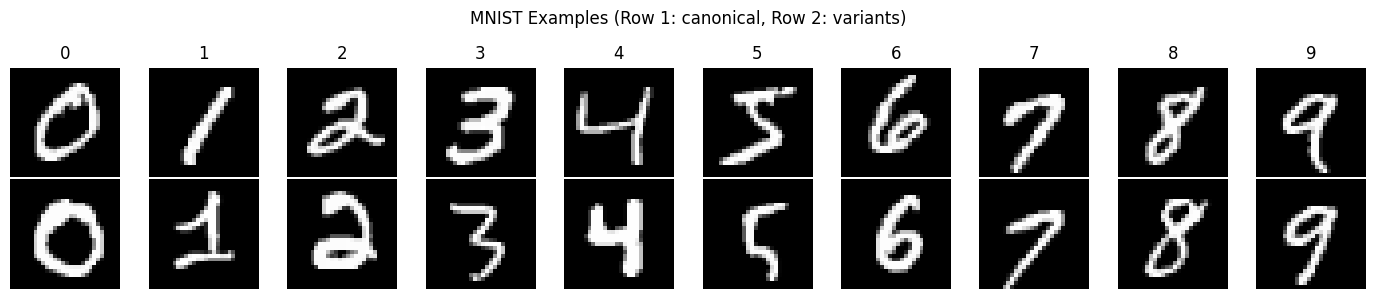

In [19]:
# Download MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=256, shuffle=False)

print(f"Train samples: {len(train_dataset)} | Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}  (C x H x W)")
print(f"Number of classes: {len(train_dataset.classes)}")

# Visualize some examples
fig, axes = plt.subplots(2, 10, figsize=(14, 3))
for digit in range(10):
    # Find first example of each digit
    idx = (torch.tensor(train_dataset.targets) == digit).nonzero()[0].item()
    img = train_dataset[idx][0].squeeze().numpy()
    axes[0, digit].imshow(img, cmap='gray')
    axes[0, digit].set_title(str(digit), fontsize=12)
    axes[0, digit].axis('off')

# Show pixel intensity distribution for one image
sample_img = train_dataset[0][0].squeeze().numpy()
for i in range(10):
    idx2 = (torch.tensor(train_dataset.targets) == i).nonzero()[5].item()
    img2 = train_dataset[idx2][0].squeeze().numpy()
    axes[1, i].imshow(img2, cmap='gray')
    axes[1, i].axis('off')

fig.suptitle('MNIST Examples (Row 1: canonical, Row 2: variants)', fontsize=12)
plt.tight_layout()
plt.show()

### Step 2 — Build the MLP Architecture

In [20]:
# PROJECT Step 2: Build your MNIST MLP
#
# Architecture to implement:
#   Input: 784 (= 28*28 flattened)
#   Hidden 1: 512 neurons, ReLU
#   Dropout: p=0.3  ← reduces overfitting
#   Hidden 2: 256 neurons, ReLU
#   Dropout: p=0.3
#   Hidden 3: 128 neurons, ReLU
#   Output: 10 neurons (no activation — CrossEntropyLoss handles it)
#
# Tip: use x.view(x.size(0), -1) in forward() to flatten images

class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO
        pass

    def forward(self, x):
        # x shape: (batch, 1, 28, 28)
        # TODO
        pass

# model_mnist = MNISTClassifier()
# print(model_mnist)
# print(f"Total parameters: {sum(p.numel() for p in model_mnist.parameters()):,}")

### Step 3 — Training Loop

In [22]:
# PROJECT Step 3: Implement the training and evaluation functions
#
# train_epoch(model, loader, optimizer, criterion):
#   → iterate over batches, compute loss, backprop, return avg loss & accuracy
#
# evaluate(model, loader, criterion):
#   → evaluate without computing gradients, return avg loss & accuracy

def train_epoch(model, loader, optimizer, criterion):
    # TODO
    pass

def evaluate(model, loader, criterion):
    # TODO
    pass

### Step 4 — Train and Monitor

In [35]:
# Step 4

torch.manual_seed(42)
model_mnist = MNISTClassifier()
criterion_mnist = nn.CrossEntropyLoss()
optimizer_mnist = optim.Adam(model_mnist.parameters(), lr=1e-3)

EPOCHS_MNIST = 15
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Train Acc':>9} | {'Test Loss':>9} | {'Test Acc':>8}")
print("-" * 56)

for epoch in range(1, EPOCHS_MNIST + 1):
    tr_loss, tr_acc = train_epoch(model_mnist, train_loader, optimizer_mnist, criterion_mnist)
    te_loss, te_acc = evaluate(model_mnist, test_loader, criterion_mnist)

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['test_loss'].append(te_loss)
    history['test_acc'].append(te_acc)

    print(f"{epoch:>5} | {tr_loss:>10.4f} | {tr_acc*100:>8.2f}% | {te_loss:>9.4f} | {te_acc*100:>7.2f}%")

print(f"\n✓ Final Test Accuracy: {history['test_acc'][-1]*100:.2f}%")

Epoch | Train Loss | Train Acc | Test Loss | Test Acc
--------------------------------------------------------
    1 |     0.3078 |    90.51% |    0.1182 |   96.41%
    2 |     0.1316 |    96.03% |    0.0882 |   97.18%
    3 |     0.1022 |    96.97% |    0.0903 |   97.50%
    4 |     0.0857 |    97.39% |    0.0729 |   97.92%
    5 |     0.0782 |    97.56% |    0.0767 |   97.75%
    6 |     0.0649 |    97.99% |    0.0701 |   97.97%
    7 |     0.0611 |    98.12% |    0.0701 |   98.05%
    8 |     0.0554 |    98.28% |    0.0756 |   97.98%
    9 |     0.0520 |    98.31% |    0.0605 |   98.19%
   10 |     0.0496 |    98.43% |    0.0620 |   98.42%
   11 |     0.0443 |    98.59% |    0.0622 |   98.24%
   12 |     0.0426 |    98.67% |    0.0638 |   98.05%
   13 |     0.0417 |    98.72% |    0.0689 |   98.05%
   14 |     0.0394 |    98.74% |    0.0667 |   98.14%
   15 |     0.0379 |    98.79% |    0.0727 |   98.29%

✓ Final Test Accuracy: 98.29%


### Step 5 — Analysis and Visualizations

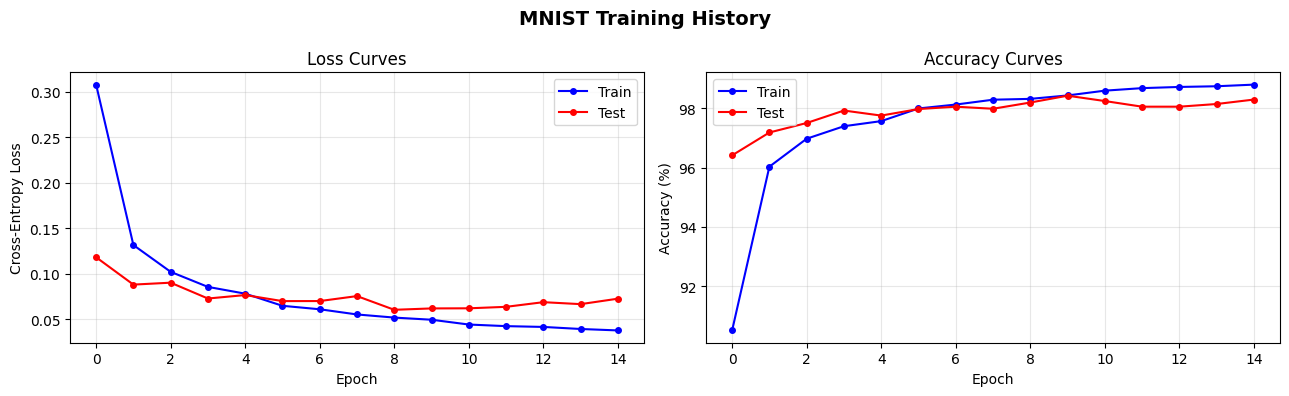

In [37]:
# Step 5a: Training curves

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].plot(history['train_loss'], 'b-o', markersize=4, label='Train')
axes[0].plot(history['test_loss'],  'r-o', markersize=4, label='Test')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Cross-Entropy Loss')
axes[0].set_title('Loss Curves'); axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot([a*100 for a in history['train_acc']], 'b-o', markersize=4, label='Train')
axes[1].plot([a*100 for a in history['test_acc']],  'r-o', markersize=4, label='Test')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Curves'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.suptitle('MNIST Training History', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()

C:\Users\ahuss\AppData\Local\Temp\ipykernel_29152\1039859077.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_all  = torch.tensor(test_dataset.targets)


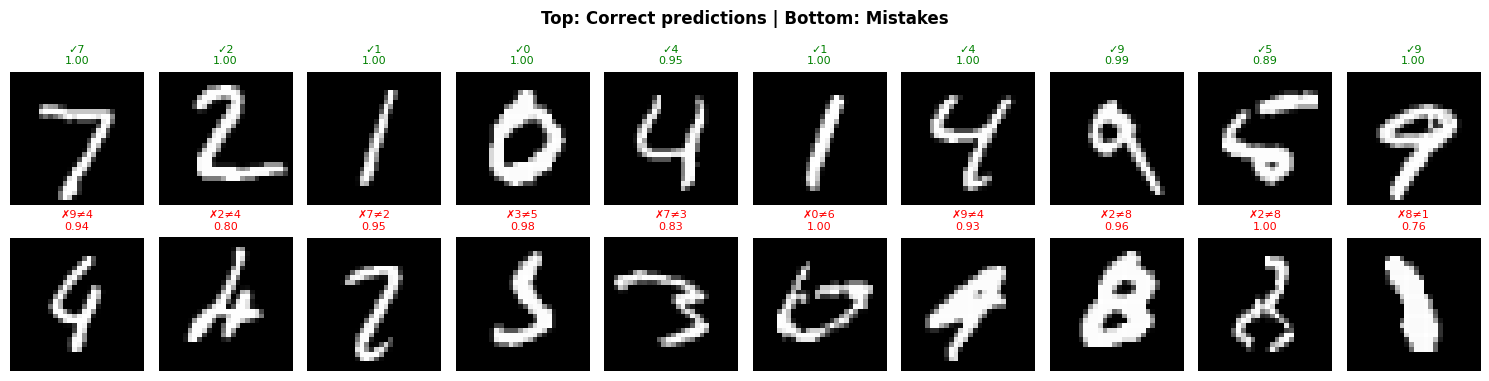

Total errors on test set: 171 / 10000
Note: Many errors are on ambiguous or poorly written digits.


In [36]:
# Step 5b - model_mnist.eval()

# Collect test images + predictions
X_test_all = test_dataset.data.float().unsqueeze(1) / 255.0
X_test_all = (X_test_all - 0.1307) / 0.3081  # normalize
y_test_all  = torch.tensor(test_dataset.targets)

with torch.no_grad():
    logits_all = model_mnist(X_test_all)
    probs_all  = torch.softmax(logits_all, dim=1)
    preds_all  = logits_all.argmax(1)

correct_mask   = (preds_all == y_test_all)
incorrect_mask = ~correct_mask

fig, axes = plt.subplots(2, 10, figsize=(15, 4))
fig.suptitle('Top: Correct predictions | Bottom: Mistakes', fontsize=12, fontweight='bold')

correct_idx   = correct_mask.nonzero().squeeze()[:10]
incorrect_idx = incorrect_mask.nonzero().squeeze()[:10]

for col, (ci, ii) in enumerate(zip(correct_idx, incorrect_idx)):
    # Correct
    img_c = X_test_all[ci].squeeze().numpy()
    conf_c = probs_all[ci, preds_all[ci]].item()
    axes[0, col].imshow(img_c, cmap='gray')
    axes[0, col].set_title(f"✓{preds_all[ci].item()}\n{conf_c:.2f}", fontsize=8, color='green')
    axes[0, col].axis('off')

    # Incorrect
    img_i = X_test_all[ii].squeeze().numpy()
    conf_i = probs_all[ii, preds_all[ii]].item()
    axes[1, col].imshow(img_i, cmap='gray')
    axes[1, col].set_title(f"✗{preds_all[ii].item()}≠{y_test_all[ii].item()}\n{conf_i:.2f}", fontsize=8, color='red')
    axes[1, col].axis('off')

plt.tight_layout(); plt.show()

print(f"Total errors on test set: {incorrect_mask.sum().item()} / {len(y_test_all)}")
print("Note: Many errors are on ambiguous or poorly written digits.")

---
## 🏁 Summary & Key Takeaways

| Concept | Key Message |
|---|---|
| **Perceptron** | Linear model — cannot learn non-linear patterns |
| **Hidden layers** | Add expressiveness — 1 layer is already a universal approximator |
| **Depth** | Deeper = more abstract features, but harder to train |
| **Activation functions** | Essential for non-linearity; ReLU best avoids vanishing gradient |
| **Vanishing gradient** | Sigmoid saturate → early layers stop learning |
| **MSELoss** | For regression (continuous output) |
| **CrossEntropyLoss** | For classification |
| **Dropout** | Simple regularization — drops neurons randomly during training |
| **MNIST** | A standard benchmark — >97% accuracy achievable with MLP |

### Going further
- **Convolutional Networks (CNN)**: exploit spatial structure of images → state of the art on MNIST (>99.5%)